In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline


In [2]:
# This file contains all the main external libs we'll use
from fastai.imports import *

In [3]:

import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import pathlib


In [4]:
torch.cuda.is_available()
torch.backends.cudnn.enabled


True

In [5]:
#overcast 20191030T161529_VOOR
#partly 20191112T183029_VOOR
#clear 20190511T122529_VOOR
PATH = '/home/arnold/clouds_detection/VOOR'
data_dir = pathlib.Path(PATH)
#resize image 
# sz=224
# List containing the entries in the directory given by PATH
os.listdir(PATH)
image_count = len(list(data_dir.glob('*/*.jpg')))

batch_size = 32
img_height = 720
img_width = 1080

print(image_count)

1349


In [6]:
rains = list(data_dir.glob('rain/*'))
# PIL.Image.open(str(roses[0]))

In [7]:
files = os.listdir(f'{PATH}/clear')[:10]
files

['20190607T131529_VOOR.jpg',
 '20190301T135030_VOOR.jpg',
 '20190607T135030_VOOR.jpg',
 '20190320T221030_VOOR.jpg',
 '20190301T164029_VOOR.jpg',
 '20190607T144030_VOOR.jpg',
 '20190320T150540_VOOR.jpg',
 '20190301T152029_VOOR.jpg',
 '20190320T124530_VOOR.jpg',
 '20190320T141530_VOOR.jpg']

(720, 1280, 3)

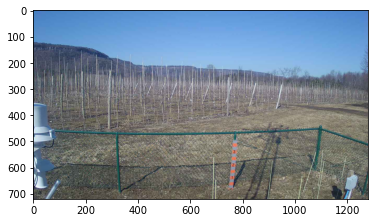

In [8]:
img = plt.imread(f'{PATH}/clear/{files[9]}')
plt.imshow(img);
img.shape
# First 4 rows and columns of the image
#img[:4,:4]

240


(240, 1280, 3)

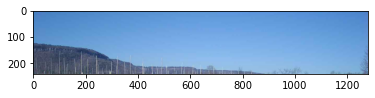

In [9]:
#cropping top of image 
height, width, channels = img.shape
print(int(height/3))
croppedImage = img[0:int(height/3), 0:width] #this line crops
# croppedImage = img[0:360, 0:width] #this line crops

plt.imshow(croppedImage);
croppedImage.shape

TensorShape([240, 1280, 3])

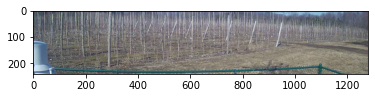

In [10]:
#cropping center
image = tf.image.resize_with_crop_or_pad(img, 240, 1280) 
image = tf.image.random_crop(image, size=[240, 1280, 3])
plt.imshow(image);
image.shape
# Random crop back to the original size
#   image = tf.image.random_crop(image, size=[IMG_SIZE, IMG_SIZE, 3])

In [11]:
input_shape = (1,720, 1280, 3)
print(input_shape)
x = np.arange(np.prod(input_shape)).reshape(input_shape)
y = tf.keras.layers.Cropping2D(cropping=((2, 2), (4, 4)))(x)
print(y.shape)

(1, 720, 1280, 3)
(1, 716, 1272, 3)


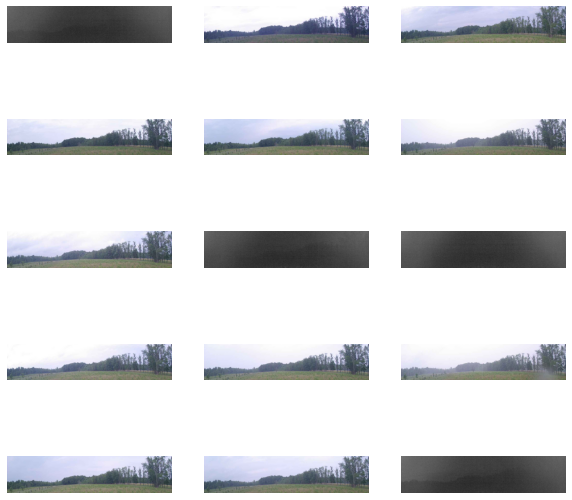

In [12]:
#WORKS to crop multi images now need to save them for a model

folder_path = '/home/mesonet/cam_photos/2018/08/17/ESSX'
from keras.preprocessing import image

# load all images into a list
paths = []
images = []
for img in os.listdir(folder_path):
    img = os.path.join(folder_path, img)
    paths.append(img)
    img = image.load_img(img, target_size=(img_height, img_width))
    img = image.img_to_array(img)
    img = img[0:int(height/3), 0:width]
    img = np.expand_dims(img, axis=0)
    images.append(img)
# print(images[1])
# stack up images list to pass for prediction
images = np.vstack(images)

#print(paths[-1])
#PIL.Image.open(paths[-1])
plt.figure(figsize=(10, 10))
for i in range(15):
    ax = plt.subplot(5, 3, i + 1)
    plt.imshow(images[i].astype("uint8"))
    plt.axis("off")

In [13]:
def read_dirs(path, folder):
    labels, filenames, all_labels = [], [], []
    full_path = os.path.join(path, folder)
    for label in sorted(os.listdir(full_path)):
        if label not in ('.ipynb_checkpoints'):
            all_labels.append(label)
            for fname in os.listdir(os.path.join(full_path, label)):
                filenames.append(os.path.join(folder, label, fname))
                labels.append(label)
    return filenames, labels, all_labels

In [14]:
#run rm -rf .ipynb_checkpoints to get correct class names

In [15]:
# #look under fine tune in https://www.tensorflow.org/tutorials/load_data/images to add cropping into pipeline myself

# train_ds = tf.keras.preprocessing.image_dataset_from_directory(
#   data_dir,
#   validation_split=0.2,
#   subset="training",
# #   seed=123,
#   image_size=(img_height, img_width),
#   batch_size=batch_size)

In [16]:
# val_ds = tf.keras.preprocessing.image_dataset_from_directory(
#   data_dir,
#   validation_split=0.2,
#   subset="validation",
# #   seed=123,
#   image_size=(img_height, img_width),
#   batch_size=batch_size)

In [17]:
#use this manual method orr above if not cropping
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'), shuffle=False)
list_ds = list_ds.shuffle(image_count, reshuffle_each_iteration=False)
for f in list_ds.take(5):
  print(f.numpy())

class_names = np.array(sorted([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"]))
print(class_names)
#split into training and val 
val_size = int(image_count * 0.2)
train_ds = list_ds.skip(val_size)
val_ds = list_ds.take(val_size)

print(tf.data.experimental.cardinality(train_ds).numpy())
print(tf.data.experimental.cardinality(val_ds).numpy())


b'/home/arnold/clouds_detection/VOOR/clear/20190320T134030_VOOR.jpg'
b'/home/arnold/clouds_detection/VOOR/night/20190606T080526_VOOR.jpg'
b'/home/arnold/clouds_detection/VOOR/night/20190202T020029_VOOR.jpg'
b'/home/arnold/clouds_detection/VOOR/clear/20190320T132530_VOOR.jpg'
b'/home/arnold/clouds_detection/VOOR/snow/20180302T151528_VOOR.jpg'
['clear' 'few' 'night' 'overcast' 'rain' 'scattered' 'snow']
1080
269


In [18]:
def get_label(file_path):
  # convert the path to a list of path components
    parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
    one_hot = parts[-2] == class_names
  # Integer encode the label
    return tf.argmax(one_hot)

def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
    img = tf.image.decode_jpeg(img, channels=3)
  # resize the image to the desired size
    return tf.image.resize(img, [img_height, img_width])


def process_path(file_path):
    label = get_label(file_path)
  # load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
#     img = image.img_to_array(img)
    height, width, channels = img.shape
#     img = img[0:int(height/3), 0:width] #1/3 top 
    img = img[0:int(height/2), 0:width] #half
    print(img.shape)
    return img, label

In [19]:
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(process_path, num_parallel_calls=AUTOTUNE)

for image, label in train_ds.take(1):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy())

(360, 1080, 3)
(360, 1080, 3)
Image shape:  (360, 1080, 3)
Label:  5


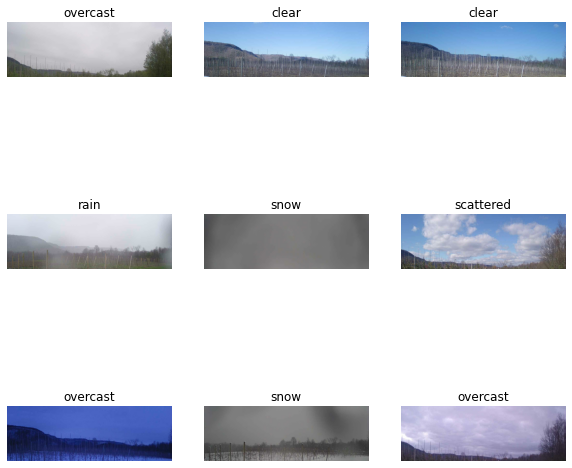

In [20]:
def configure_for_performance(ds):
    ds = ds.cache()
    ds = ds.shuffle(buffer_size=1000)
    ds = ds.batch(batch_size)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)

image_batch, label_batch = next(iter(train_ds))

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    label = label_batch[i]
    plt.title(class_names[label])
    plt.axis("off")

In [22]:
model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=3
)

NameError: name 'model' is not defined

In [21]:
class_names = train_ds.class_names
print(class_names)
print(train_ds)

AttributeError: 'PrefetchDataset' object has no attribute 'class_names'

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
#tensor of shape (bathsize, hgt, width, rgb)
#call .numpy() on the image_batch and labels_batch tensors to convert them to a numpy.ndarray
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

In [ ]:
#NOTE
'''
Dataset.cache() keeps the images in memory after they're loaded off disk during the first epoch. 
This will ensure the dataset does not become a bottleneck while training your model. 
If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.

Dataset.prefetch() overlaps data preprocessing and model execution while training.
'''
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
#RGB channel values are in the [0, 255] range. Bad for neural network; want input values small. 
#Standardize values to be in the [0, 1] by using a Rescaling layer.
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)


In [ ]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image)) 

In [ ]:
# num_classes = 7
# #build the model
# model = Sequential([
#   layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
#   layers.Conv2D(16, 3, padding='same', activation='relu'),
#   layers.MaxPooling2D(),
#   layers.Conv2D(32, 3, padding='same', activation='relu'),
#   layers.MaxPooling2D(),
#   layers.Conv2D(64, 3, padding='same', activation='relu'),
#   layers.MaxPooling2D(),
#   layers.Flatten(),
#   layers.Dense(128, activation='relu'),
#   layers.Dense(num_classes)
# ])

In [ ]:
# #compile the model (To view training and validation accuracy for each training epoch, pass the metrics argument)

# model.compile(optimizer='adam',
#               loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#               metrics=['accuracy'])

In [ ]:
# #View all the layers of the network using the model's summary method:
# model.summary()


In [ ]:
# #train the model
# epochs=40
# history = model.fit(
#   train_ds,
#   validation_data=val_ds,
#   epochs=epochs
# )

In [ ]:
# #visualize training results
# acc = history.history['accuracy']
# val_acc = history.history['val_accuracy']

# loss=history.history['loss']
# val_loss=history.history['val_loss']

# epochs_range = range(epochs)

# plt.figure(figsize=(8, 8))
# plt.subplot(1, 2, 1)
# plt.plot(epochs_range, acc, label='Training Accuracy')
# plt.plot(epochs_range, val_acc, label='Validation Accuracy')
# plt.legend(loc='lower right')
# plt.title('Training and Validation Accuracy')

# plt.subplot(1, 2, 2)
# plt.plot(epochs_range, loss, label='Training Loss')
# plt.plot(epochs_range, val_loss, label='Validation Loss')
# plt.legend(loc='upper right')
# plt.title('Training and Validation Loss')
# plt.show()

# '''
# NOTE
# if training accuracy and validation accuracy are off by large margin then need to tune the model and its overfitting
# overfitting if diiff in acc between training and val accuracy is noticeable
# also if training acc inc linearly but val acc stalls around 50-60%

# FIX:
# 'When there are a small number of training examples, the model sometimes learns from noises or unwanted details from training examples—to an extent that it negatively impacts the performance of the model on new examples. This phenomenon is known as overfitting. It means that the model will have a difficult time generalizing on a new dataset.

# There are multiple ways to fight overfitting in the training process. In this tutorial, you'll use data augmentation and add Dropout to your model.'
# '''

In [ ]:
# #save the model
# model.save("/home/arnold/raindrop-detection-cnn/models/custom_cloud_classification")

In [ ]:
#Data augmentation - generating additional training data from your existing examples by augmenting then using random transformations that yield believable-looking images
data_augmentation = keras.Sequential(
  [
      tf.keras.layers.experimental.preprocessing.RandomCrop(
    240, 1280
)
#     layers.experimental.preprocessing.RandomFlip("horizontal", 
#                                                  input_shape=(img_height, 
#                                                               img_width,
#                                                               3)),
#     layers.experimental.preprocessing.RandomRotation(0.1),
#     layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

In [ ]:
data_augmentation(images)

In [ ]:
#viz augmented images
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [ ]:
#Dropout takes a fractional number as its input value, in the form such as 0.1, 0.2, 0.4, etc. This means dropping out 10%, 20% or 40% of the output units randomly from the applied layer.
num_classes = 7
model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()


In [ ]:
epochs = 50
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
#overcast 20191030T161529_VOOR

#rain 20161013T164513_YORK.jpg_sliding_window.jpg

#partly 20191112T183029_VOOR

#clear 20190511T122529_VOOR
#clear 20191008T165026_BURT
#clear 20160420T221001_DELE
new_img_path = '/home/mesonet/cam_photos/2018/12/20/VOOR/20181220T175030_VOOR.jpg'
#new_img_path = '/home/arnold/raindrop-detection-cnn/mesonet/20161013T164513_YORK.jpg_sliding_window.jpg'

img = keras.preprocessing.image.load_img(
    new_img_path, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])
print(predictions)
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)
PIL.Image.open(new_img_path)


In [ ]:
model.save("/home/arnold/raindrop-detection-cnn/models/custom_cloud_classification_augmented_2_sites")

In [ ]:
#load model
# It can be used to reconstruct the model identically.
model = keras.models.load_model("/home/arnold/raindrop-detection-cnn/models/custom_cloud_classification_augmented_2_sites")

In [ ]:
folder_path = '/home/mesonet/cam_photos/2018/08/17/ESSX'
from keras.preprocessing import image

# load all images into a list
paths = []
images = []
for img in os.listdir(folder_path):
    img = os.path.join(folder_path, img)
    paths.append(img)
    img = image.load_img(img, target_size=(img_height, img_width))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    images.append(img)
# print(images[1])
# stack up images list to pass for prediction
images = np.vstack(images)
#print(paths)
# for i in paths:
#     PIL.Image.open(i)
#

classes = model.predict_classes(images, batch_size=32)
print(class_names)
print(classes)
predictions = model.predict(images)
score = tf.nn.softmax(predictions[0])
#print(predictions)
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)
#print(paths[-1])
#PIL.Image.open(paths[-1])
plt.figure(figsize=(10, 10))
for i in range(15):
    ax = plt.subplot(5, 3, i + 1)
    plt.imshow(images[i].astype("uint8"))
#     predictions = model.predict(image[i])
#     score = tf.nn.softmax(predictions[0])
#     plt.title(class_names[np.argmax(score)], 100 * np.max(score))
    plt.title(class_names[classes[i]])
    plt.axis("off")

In [ ]:
#this will select all the file names and put them in a list (from all children sub dirs)
def getListOfFiles(dirName):
    # create a list of file and sub directories 
    # names in the given directory 
    listOfFile = os.listdir(dirName)
    allFiles = list()
    # Iterate over all the entries
    for entry in listOfFile:
        # Create full path
        fullPath = os.path.join(dirName, entry)
        # If entry is a directory then get the list of files in this directory 
        if os.path.isdir(fullPath):
            allFiles = allFiles + getListOfFiles(fullPath)
        else:
            allFiles.append(fullPath)
                
    return allFiles    



In [ ]:
import glob
class_names = ['clear', 'few', 'night', 'overcast', 'rain', 'scattered', 'snow']
listOfFiles = glob.glob('/home/mesonet/cam_photos/2019/07/*/BKLN/*')
print(len(listOfFiles))


In [ ]:
# load all images into a list
paths_all = []
images_all = []
for img in listOfFiles:
#     img = os.path.join(folder_path, img)
#     print(img)
    paths_all.append(img)
    img = image.load_img(img, target_size=(img_height, img_width))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    images_all.append(img)
# print(images_all[1])    
images_all = np.vstack(images_all)

classes = model.predict_classes(images_all, batch_size=64)
print(class_names)
print(classes)

#save predicted images to folders
#['clear', 'few', 'night', 'overcast', 'rain', 'scattered', 'snow']
print(len(classes))

r =0
for k,i in enumerate(classes):
    if i==0:
        #save image
#         print(paths_all[k][-24:])
        im = PIL.Image.fromarray(images_all[k].astype("uint8"))
        im.save("/home/arnold/raindrop-detection-cnn/ALL/clear/"+paths_all[k][-24:])
    elif i==1:
#         print(paths_all[k])
        im = PIL.Image.fromarray(images_all[k].astype("uint8"))
        im.save("/home/arnold/raindrop-detection-cnn/ALL/few/"+paths_all[k][-24:])
    elif i==2:
#         print(paths_all[k])
        im = PIL.Image.fromarray(images_all[k].astype("uint8"))
        im.save("/home/arnold/raindrop-detection-cnn/ALL/night/"+paths_all[k][-24:])
    elif i==3:
#         print(paths_all[k])
        im = PIL.Image.fromarray(images_all[k].astype("uint8"))
        im.save("/home/arnold/raindrop-detection-cnn/ALL/overcast/"+paths_all[k][-24:])    
    elif i==4:
#         print(paths_all[k])
        im = PIL.Image.fromarray(images_all[k].astype("uint8"))
        im.save("/home/arnold/raindrop-detection-cnn/ALL/rain/"+paths_all[k][-24:])
    elif i==5:
#         print(paths_all[k])
        im = PIL.Image.fromarray(images_all[k].astype("uint8"))
        im.save("/home/arnold/raindrop-detection-cnn/ALL/scattered/"+paths_all[k][-24:])
    elif i==6:
#         print(paths_all[k])
        im = PIL.Image.fromarray(images_all[k].astype("uint8"))
        im.save("/home/arnold/raindrop-detection-cnn/ALL/snow/"+paths_all[k][-24:])

In [ ]:
plt.figure(figsize=(10, 10))
for i in range(15):
    ax = plt.subplot(5, 3, i + 1)
    plt.imshow(images_all[i].astype("uint8"))
#     predictions = model.predict(image[i])
#     score = tf.nn.softmax(predictions[0])
#     plt.title(class_names[np.argmax(score)], 100 * np.max(score))
    plt.title(class_names[classes[i]])
    plt.axis("off")

In [ ]:
# #save predicted images to folders
# #['clear', 'few', 'night', 'overcast', 'rain', 'scattered', 'snow']
# print(len(classes))

# r =0
# for k,i in enumerate(classes):
#     if i==4:
#         #save image
#         print(paths_all[k][-24:])
# #         im = PIL.Image.fromarray(images_all[k].astype("uint8"))
# #         im.save("/home/arnold/raindrop-detection-cnn/VOOR/rain/"+paths_all[k][-24:])
#     elif i==6:
#         print(paths_all[k])



In [ ]:
# print (class_names)
j=0
rain_imgs = []
plt.figure(figsize=(10, 9))
for k,i in enumerate(classes):
#     print(k,i)
    if i==6:
        j += 1
        rain_imgs.append(images_all[k])
#         plt.subplot(3,4,i+1)
#         plt.imshow(images_all[k].astype("uint8"))
#         plt.title(class_names[i])
#         plt.axis('off')
#         print(j)
#         print(class_names[i])
#         plt.imshow(images_all[i].astype("uint8"))
# print(rain_imgs)
print(j)
    

In [ ]:
plt.figure(figsize=(10, 9))
# print((rain_imgs[1]))
# plt.imshow(rain_imgs[1].astype("uint8"))
# plt.imshow(rain_imgs[2].astype("uint8"))



for i in range(11):
    plt.subplot(4,3,i+1)
    plt.imshow(rain_imgs[i].astype("uint8"))
#     plt.title(class_names[i])
    plt.axis('off')

In [ ]:
tf_model_predictions = model.predict(images)


In [ ]:
print(tf_model_predictions.shape) #“Prediction results shape:”, (219, 7)
predicted_ids = np.argmax(tf_model_predictions, axis=-1)
# predicted_labels = class_names[predicted_ids]
print(predicted_ids)

In [ ]:
plt.figure(figsize=(15,15))
plt.subplots_adjust(hspace=0.5)
for n in range(36): #predicted_labels
    plt.subplot(6,6,n+1)
    plt.imshow(images[n].astype("uint8"))
#     color = "green" if predicted_ids[n] == true_label_ids[n] else "red"
    plt.title(class_names[predicted_ids[n]]) #predicted_labels
    plt.axis('off')
#     _ = plt.suptitle("Model predictions (green: correct, red: incorrect)")